# Image Classification Human vs Horse

## Problem Definition - Main Objective

Company XYZ would like to build a Deep Learning model to classify horse vs human images. The images are of horses and humans, and the classification task is to predict whether the image is a horse or a human.
With pre-trained models like InceptionV3, the model can be trained to classify images.

In [1]:
# import required libraries
import os
import zipfile
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop


## Data Set collection

In [2]:
# Get the Horse or Human dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

# Get the Horse or Human Validation dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 

--2022-05-16 04:54:18--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 142.250.4.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  88.6MB/s    in 1.6s    

2022-05-16 04:54:20 (88.6 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2022-05-16 04:54:20--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 172.217.194.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114

In [3]:
# all the required train and validation files are available in a zip file. Unzip the files for training and validation
local_zip = '//tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = '//tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

In [4]:
# Lets assign dedicated folder for training and validation
train_horses_dir = '/tmp/training/horses'
train_humans_dir = '/tmp/training/humans'
validation_horses_dir = '/tmp/validation/horses'
validation_humans_dir = '/tmp/validation/humans'

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print('Total Horse Training files',len(train_horses_fnames))
print('Total Horse Training files',len(train_humans_fnames))
print('Total Horse Training files',len(validation_horses_fnames))
print('Total Horse Training files',len(validation_humans_fnames))

Total Horse Training files 500
Total Horse Training files 527
Total Horse Training files 128
Total Horse Training files 128


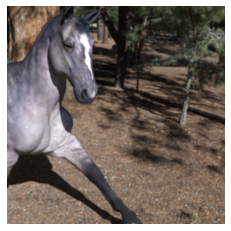

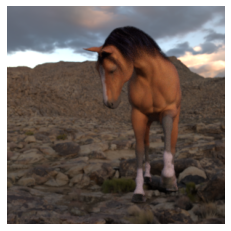

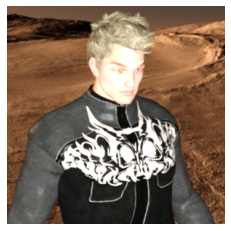

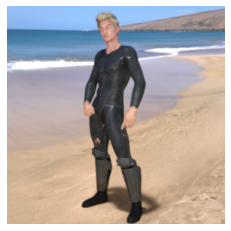

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_horse = [os.path.join(train_horses_dir, fname) 
                for fname in train_horses_fnames[pic_index-2:pic_index]]
next_human = [os.path.join(train_humans_dir, fname) 
                for fname in train_humans_fnames[pic_index-2:pic_index]]


for i, img_path in enumerate(next_horse+next_human):
  #print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()


In [6]:
# Define our example directories and files
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True
                                   )

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(# Your Code Here
                                  rescale = 1./255.,
                                  )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(# Your Code Here
                                                    train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150)
                                                    )     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( # Your Code Here
                                                         validation_dir,
                                                         batch_size = 20,
                                                         class_mode = 'binary',
                                                         target_size = (150, 150)
                                                         )

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


### Dataset Description

We have got 1027 images for training and 256 images for validation. 

Below is the highlevel break down for each these classes ( Horse vs Human )

* Total Horse Training files 500
* Total Horse Training files 527
* Total Horse Training files 128
* Total Horse Training files 128

## Model building

#### Reusable methods

In [7]:
# method to display loss vs accuracy graph

import matplotlib.pyplot as plt

def plot_graph(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend(loc=0)
  plt.figure()

  plt.show()

In [8]:
# Define a Callback class that stops training once accuracy reaches 99.9% We dont want to overfit our model.
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

# Callback for early stopping. If training loss didnt improve after 10 epoch stop training
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

### Basic CNN for Image Classification

We will use a basic CNN first to explore the model building before we use Transfer learning

In [9]:
# Basic CNN Model building
cnn_model = tf.keras.models.Sequential([
# YOUR CODE HERE
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horse') and 1 for the other ('human')
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

cnn_model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [10]:
BATCH_SIZE = 20
TRAIN_STEPS_PER_EPOCH = len(train_horses_fnames)//BATCH_SIZE
VAL_STEPS_PER_EPOCH = len(validation_horses_fnames)//BATCH_SIZE
callbacks = myCallback()
cnn_history = cnn_model.fit(
                    train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = TRAIN_STEPS_PER_EPOCH * 2,
                    epochs = 100,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    verbose = 1,
                    callbacks=[callbacks, es_callback]
                    )

Epoch 1/100
50/50 [==============================] - 17s 229ms/step - loss: 0.8494 - accuracy: 0.6140 - val_loss: 1.5633 - val_accuracy: 0.4583
Epoch 2/100
50/50 [==============================] - 10s 203ms/step - loss: 0.5895 - accuracy: 0.7457 - val_loss: 1.7347 - val_accuracy: 0.5000
Epoch 3/100
50/50 [==============================] - 10s 201ms/step - loss: 0.4393 - accuracy: 0.8004 - val_loss: 2.5188 - val_accuracy: 0.5333
Epoch 4/100
50/50 [==============================] - 10s 206ms/step - loss: 0.3536 - accuracy: 0.8318 - val_loss: 4.0049 - val_accuracy: 0.5167
Epoch 5/100
50/50 [==============================] - 10s 204ms/step - loss: 0.3385 - accuracy: 0.8561 - val_loss: 2.3794 - val_accuracy: 0.4750
Epoch 6/100
50/50 [==============================] - 11s 214ms/step - loss: 0.2583 - accuracy: 0.8875 - val_loss: 1.7181 - val_accuracy: 0.6667
Epoch 7/100
50/50 [==============================] - 10s 202ms/step - loss: 0.1962 - accuracy: 0.9230 - val_loss: 3.5932 - val_accuracy:

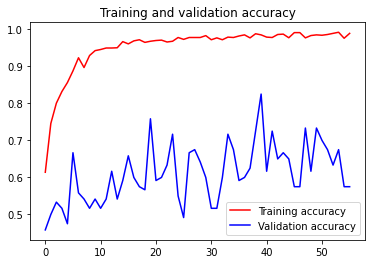

<Figure size 432x288 with 0 Axes>

In [11]:
plot_graph(cnn_history)

The training stopped after 54th epoch. There is no improvement in the training loss. 

Lets try to repeat the experiment with Transfer Learning

### InceptionV3

In [12]:
# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_inception_model = InceptionV3(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)

### Freeze top layers and build the model

In [20]:
# we will use Functional API to merge both pretrained model and our custom model
def build_model(pretrained_model):
  # Make all the layers in the pre-trained model non-trainable
  for layer in pretrained_model.layers:
    layer.trainable = False
  last_layer = pretrained_model.get_layer('block5_pool') # block5_pool mixed7
  print('last layer output shape: ', last_layer.output_shape)
  last_output = last_layer.output
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)
  # Add a fully connected layer with 1,024 hidden units and ReLU activation
  x = layers.Dense(1024, activation='relu')(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.2)(x)                  
  # Add a final sigmoid layer for classification
  x = layers.Dense  (1, activation='sigmoid')(x)           

  model = Model( pretrained_model.input, x) 

  model.compile(optimizer=RMSprop(learning_rate=0.001), 
                loss = 'binary_crossentropy', 
                metrics = ['accuracy'])
  return model

## Model Training

In [14]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99.9% accuracy
# (It should take less than 100 epochs)
BATCH_SIZE = 20
TRAIN_STEPS_PER_EPOCH = len(train_horses_fnames)//BATCH_SIZE
VAL_STEPS_PER_EPOCH = len(validation_horses_fnames)//BATCH_SIZE
callbacks = myCallback()
inception_model = build_model(pre_trained_inception_model)
inception_history = inception_model.fit(
                    train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = TRAIN_STEPS_PER_EPOCH * 2,
                    epochs = 100,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    verbose = 1,
                    callbacks=[callbacks, es_callback]
                    )

last layer output shape:  (None, 7, 7, 768)
Epoch 1/100
50/50 [==============================] - 15s 233ms/step - loss: 1.2128 - accuracy: 0.9230 - val_loss: 0.0134 - val_accuracy: 0.9917
Epoch 2/100
50/50 [==============================] - 11s 214ms/step - loss: 0.1825 - accuracy: 0.9737 - val_loss: 6.9436e-08 - val_accuracy: 1.0000
Epoch 3/100
50/50 [==============================] - 11s 214ms/step - loss: 0.1069 - accuracy: 0.9838 - val_loss: 0.3799 - val_accuracy: 0.9667
Epoch 4/100
50/50 [==============================] - 11s 216ms/step - loss: 0.1054 - accuracy: 0.9889 - val_loss: 0.0062 - val_accuracy: 0.9917
Epoch 5/100
50/50 [==============================] - 11s 217ms/step - loss: 0.1261 - accuracy: 0.9919 - val_loss: 0.0268 - val_accuracy: 0.9917
Epoch 6/100
50/50 [==============================] - 11s 214ms/step - loss: 0.0918 - accuracy: 0.9868 - val_loss: 0.2998 - val_accuracy: 0.9667
Epoch 7/100
50/50 [==============================] - 11s 214ms/step - loss: 0.0745 - acc

We reched 99.9% accuracy with in 30th Epoch itself

### Model Accuracy

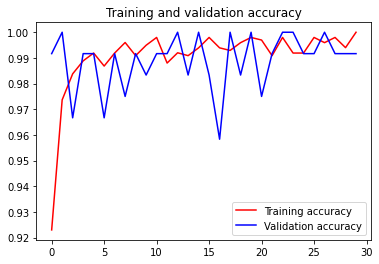

<Figure size 432x288 with 0 Axes>

In [15]:
plot_graph(inception_history)

### VGG16

In [16]:
# Import the inception model
from tensorflow.keras.applications.vgg16 import VGG16

pre_trained_VGG16_model = VGG16(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet' # we will use the same imagenet weights
)

In [ ]:
vgg16_model = build_model(pre_trained_VGG16_model)
vgg16_model_history = vgg16_model.fit(
                    train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = TRAIN_STEPS_PER_EPOCH * 2,
                    epochs = 100,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    verbose = 1,
                    callbacks=[callbacks, es_callback]
                    )
plot_graph(inception_history)

last layer output shape:  (None, 4, 4, 512)
Epoch 1/100
50/50 [==============================] - 14s 240ms/step - loss: 1.2749 - accuracy: 0.7822 - val_loss: 0.5556 - val_accuracy: 0.8667
Epoch 2/100
50/50 [==============================] - 11s 225ms/step - loss: 0.3983 - accuracy: 0.8734 - val_loss: 0.0634 - val_accuracy: 0.9750
Epoch 3/100
50/50 [==============================] - 12s 237ms/step - loss: 0.2314 - accuracy: 0.9129 - val_loss: 0.0550 - val_accuracy: 0.9667
Epoch 4/100
50/50 [==============================] - 11s 225ms/step - loss: 0.2287 - accuracy: 0.9210 - val_loss: 1.0257 - val_accuracy: 0.8167
Epoch 5/100
50/50 [==============================] - 11s 227ms/step - loss: 0.1488 - accuracy: 0.9440 - val_loss: 0.3148 - val_accuracy: 0.9500
Epoch 6/100
50/50 [==============================] - 11s 225ms/step - loss: 0.1544 - accuracy: 0.9605 - val_loss: 0.1608 - val_accuracy: 0.9583
Epoch 7/100
50/50 [==============================] - 11s 222ms/step - loss: 0.1938 - accurac